# Citizen weather stations data

In this notebook, we will assemble a time series of meteorological measurements from the citizen weather stations (CWS) in the study region for the heatwave period determined using the official weather stations data.

In [ ]:
import datetime
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from meteora.clients import NetatmoClient

from uhi_cws_lausanne import plot_utils

NETATMO_SCALE = "1hour"  # could also be "30min"

In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"

# official station data just to get the time range
official_ts_df_filepath = "../data/interim/official-ts-df.csv"

# we need to dump both the time series of measurements and the stations' locations
dst_ts_df_filepath = "../data/raw/cws-ts-df.csv"
dst_stations_gdf_filepath = "../data/raw/cws-stations.gpkg"

# plotting
# xmargin = 0  # uplt.rc["axes.xmargin"]
# refwidth = 3  # uplt.rc["subplots.refwidth"]
# uplt.rc.update(**{"axes.xmargin": xmargin, "subplots.refwidth": refwidth})

In [ ]:
# heatwave start and end
# add one extra hour before and after because of how the netatmo API works
heatwave_range_df = (
    pd.read_csv(official_ts_df_filepath, parse_dates=["time"])
    .groupby("heatwave", sort=False)["time"]
    .agg(["min", "max"])
)
heatwave_range_df["min"] = heatwave_range_df["min"].apply(
    lambda x: x - datetime.timedelta(hours=1)
)
heatwave_range_df["max"] = heatwave_range_df["max"].apply(
    lambda x: x + datetime.timedelta(hours=2)
)
heatwave_range_df

,min,max
heatwave,,
2023/07/09-2023/07/11,2023-07-08 23:00:00,2023-07-12 01:00:00
2023/08/18-2023/08/25,2023-08-17 23:00:00,2023-08-26 01:00:00


In [ ]:
# select only land extent (agglom_extent_filepath has two geometries: land and lake)
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

client_id = os.getenv("NETATMO_CLIENT_ID")
client_secret = os.getenv("NETATMO_CLIENT_SECRET")
client = NetatmoClient(
    region=region,
    client_id=client_id,
    client_secret=client_secret,
)

100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 65.26it/s]


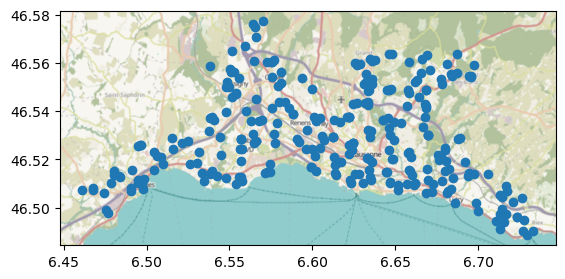

In [ ]:
fig, ax = plt.subplots()
ax = client.stations_gdf.plot(ax=ax)
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution=False)

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

In [ ]:
cws_ts_dfs = []
for heatwave, start, end in heatwave_range_df.itertuples(index=True):
    _cws_ts_df = client.get_ts_df(
        variables="temperature",
        start=start,
        end=end,
        scale=NETATMO_SCALE,
    )
    # filter by heatwave range because the API sometimes returns more records
    _cws_ts_df = _cws_ts_df[
        pd.Series(_cws_ts_df.index.get_level_values("time")).between(start, end).values
    ]
    cws_ts_dfs.append(_cws_ts_df.assign(**{"heatwave": heatwave}))

cws_ts_df = (
    pd.concat(cws_ts_dfs, axis="rows")
    .reset_index()
    .pivot(index=["heatwave", "time"], columns=["station_id"], values="temperature")
)
cws_ts_df.head()

100%|██████████████████████████████████████████████| 285/285 [00:00<00:00, 401.88it/s]


station_id                                 70:ee:50:00:0a:ce  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               12.1   
                      2023-07-09 00:30:00               11.3   
                      2023-07-09 01:30:00               10.6   
                      2023-07-09 02:30:00               10.2   
                      2023-07-09 03:30:00               10.6   

station_id                                 70:ee:50:00:0d:6c  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               23.0   
                      2023-07-09 00:30:00               22.5   
                      2023-07-09 01:30:00               21.9   
                      2023-07-09 02:30:00               21.7   
                      2023-07-09 03:30:00               21.3   

station_id                                 70:ee:50:00:1d:3c  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               21.7   
                      2023-07-09 00:30:00               21.1   
                      2023-07-09 01:30:00               20.6   
                      2023-07-09 02:30:00               20.2   
                      2023-07-09 03:30:00               19.8   

station_id                                 70:ee:50:00:28:ea  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               24.0   
                      2023-07-09 00:30:00               23.3   
                      2023-07-09 01:30:00               22.6   
                      2023-07-09 02:30:00               22.0   
                      2023-07-09 03:30:00               21.9   

station_id                                 70:ee:50:00:3b:46  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               24.4   
                      2023-07-09 00:30:00               23.9   
                      2023-07-09 01:30:00               23.1   
                      2023-07-09 02:30:00               22.6   
                      2023-07-09 03:30:00               22.2   

station_id                                 70:ee:50:00:3b:86  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               25.0   
                      2023-07-09 00:30:00               24.5   
                      2023-07-09 01:30:00               23.9   
                      2023-07-09 02:30:00               23.4   
                      2023-07-09 03:30:00               22.9   

station_id                                 70:ee:50:00:3e:82  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               22.9   
                      2023-07-09 00:30:00               22.4   
                      2023-07-09 01:30:00               21.9   
                      2023-07-09 02:30:00               21.5   
                      2023-07-09 03:30:00               21.1   

station_id                                 70:ee:50:00:5e:98  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               22.8   
                      2023-07-09 00:30:00               22.3   
                      2023-07-09 01:30:00               21.7   
                      2023-07-09 02:30:00               21.3   
                      2023-07-09 03:30:00               20.8   

station_id                                 70:ee:50:00:62:9c  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-08 23:30:00               21.5   
                      2023-07-09 00:30:00               21.2   
                      2023-07-09 01:30:00               20.3   
                      2023-07-09 02:30:00               19.5   
                      20

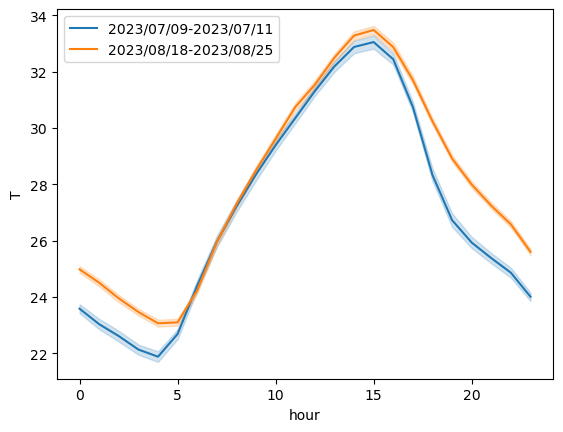

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in cws_ts_df.groupby(level="heatwave"):
    # heatwave_ts_df = heatwave_ts_df.stack(dropna=True).reset_index(name="T")
    heatwave_ts_df = heatwave_ts_df.reset_index().melt(
        id_vars=["heatwave", "time"], value_name="T"
    )
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="T",
        ax=ax,
        label=heatwave,
    )

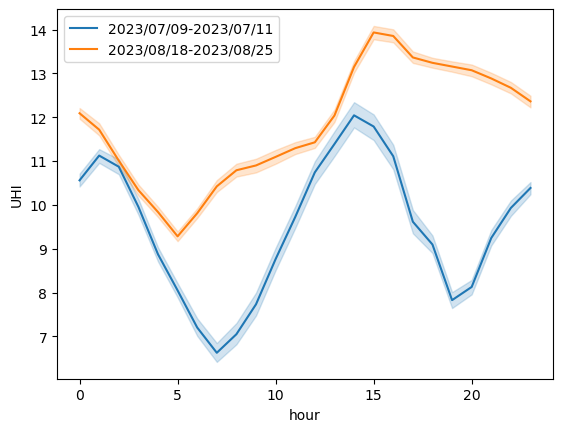

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in cws_ts_df.apply(
    lambda row: row - row.min(), axis="columns"
).groupby(level="heatwave"):
    # heatwave_ts_df = heatwave_ts_df.stack(dropna=True).reset_index(name="UHI")
    heatwave_ts_df = heatwave_ts_df.reset_index().melt(
        id_vars=["heatwave", "time"], value_name="UHI"
    )
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="UHI",
        ax=ax,
        label=heatwave,
    )

<Axes: >

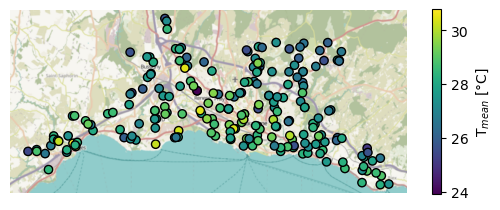

In [ ]:
# plot by average temperature
plot_kwargs = {"legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"}}
# only plot stations with a maximum proportion of nan values (just for the color scale,
# more QC to come in a separate notebook later)
reliable_max_nan = 0.2
reliable_stations = cws_ts_df.columns[
    cws_ts_df.isna().sum() / len(cws_ts_df.index) <= reliable_max_nan
]
# TODO: properly drop ugly hardcoded stations
reliable_stations = reliable_stations.difference(
    ["70:ee:50:00:0a:ce", "70:ee:50:22:b2:a0"]
)
plot_utils.plot_map_by_var(
    client.stations_gdf["geometry"],
    cws_ts_df[reliable_stations].mean().rename("T_mean"),
    **plot_kwargs,
)

In [ ]:
# dump filtered data
cws_ts_df.to_csv(dst_ts_df_filepath)
client.stations_gdf.to_file(dst_stations_gdf_filepath)